# <center>CMSC320 - Final Project (need better title)</center>
<center>Michael Reeve and Sambit Sahoo</center>

## <center>Introduction</center>





In [1]:
# imports
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date as dt, timedelta
import string
import nltk
nltk.download([
"names",
"stopwords",
"state_union",
"twitter_samples",
"movie_reviews",
"averaged_perceptron_tagger",
"vader_lexicon",
"punkt",
], quiet=True)
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

In [2]:
csv_df = pd.read_csv("cleandata.csv")
csv_df

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27 16:17:39,thanks
1,@ZubyMusic Absolutely,755,26737,2022-10-27 13:19:25,Absolutely
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27 13:08:00,Dear Twitter Advertisers
3,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26 21:39:32,Meeting a lot of cool people at Twitter today!
4,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26 18:45:58,Entering Twitter HQ – let that sink in!
...,...,...,...,...,...
2663,@LimitingThe @baglino Just that manganese is a...,171,3173,2022-01-27 22:01:06,Just that manganese is an alternative to iron ...
2664,@incentives101 @ICRicardoLara Exactly,145,4234,2022-01-27 21:23:20,Exactly
2665,@ICRicardoLara Your policies are directly resp...,421,6144,2022-01-27 21:13:57,Your policies are directly responsible for the...
2666,@ICRicardoLara You should be voted out of office,484,7029,2022-01-27 21:12:27,You should be voted out of office


This dataset contains 4 columns, raw text (Tweets), Retweets, Likes, Date, and Cleaned Tweets. The date entries contain time of day and we only care about the date, lets strip the time from these entries.

In [3]:
csv_df["Date"] = pd.to_datetime(csv_df["Date"]).dt.date
csv_df.head()

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27,thanks
1,@ZubyMusic Absolutely,755,26737,2022-10-27,Absolutely
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27,Dear Twitter Advertisers
3,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26,Meeting a lot of cool people at Twitter today!
4,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26,Entering Twitter HQ – let that sink in!


In [4]:
print(csv_df["Date"].min(), csv_df["Date"].max())

2022-01-27 2022-10-27


This dataset only contains tweets from 1/27-10/27. Let's use the Twitter API to pull tweets after 10/27 through today to add more data to analyze.

The Kaggle dataset was compiled on 10/27, meaning the like and rewteet counts are likely lower than what they would be today. We are assuming that most tweets approach a limit of likes and retweets after about a week of being posted. We are going to gather tweets from 10/20 onward and replace entries in the Kaggle dataset that overlap.

In [5]:
load_dotenv(".env")
token = os.environ.get("BEARER_TOKEN")
headers = {"Authorization": "Bearer {}".format(token)}

ELON_ID = "44196397"

search_url = "https://api.twitter.com/2/users/{}/tweets".format(ELON_ID)

query_params = {
    'start_time': '2022-10-20T00:00:00Z', # Look at tweets after 10/20/22
    'tweet.fields': 'text,created_at,public_metrics', # Retreive text of tweet, date posted, metrics(likes, retweets)
    'max_results': 100, # get 100 tweets every request (this is the max Twitter allows)
}

df = pd.DataFrame()

# because we cannot download all tweets at once, we will continue making requests using a technique called pagination (link me)
next_token = ""
while next_token is not None:
    curr_params = query_params.copy()
    if next_token != "":
        curr_params['pagination_token'] = next_token

    # make request to twitter api
    res = requests.request("GET", search_url, headers = headers, params = curr_params)
    res_json = res.json()

    # end of loop check - more on this below
    if 'data' not in res_json:
        next_token = None
        continue
    
    # remove fields Twitter gives back to us that we don't need and de-construct metrics dict
    tweets = res_json['data']
    for t in tweets:
        if 'edit_history_tweet_ids' in t:
            del t['edit_history_tweet_ids']
        if 'id' in t:
            del t['id']
        if 'public_metrics' in t:
            metrics = t['public_metrics']
            t['likes'] = metrics['like_count']
            t['retweets'] = metrics['retweet_count']
            del t['public_metrics']

    # create dataframe out of current 100 tweets then add to cumulative df
    curr_df = pd.DataFrame().from_dict(tweets)
    df = pd.concat([df, curr_df])

    # check if the next page exists, if not we end the loop by setting next_token to None
    if 'meta' in res_json:
        if 'next_token' in res_json['meta']:
            next_token = res_json['meta']['next_token']
        else:
            next_token = None
    else:
        next_token = None

In [6]:
print(len(df))
df.head()

1469


,text,created_at,likes,retweets
0,@DrJBhattacharya Thank you for your rigorous a...,2022-12-11T21:32:38.000Z,10020,1087
1,@Anonydamus1 @BillyM2k 👋,2022-12-11T21:05:28.000Z,2049,71
2,@nichegamer @BillyM2k @ScammerPayback We are m...,2022-12-11T20:27:38.000Z,5518,310
3,"@BillyM2k They will try other methods, but we’...",2022-12-11T20:18:43.000Z,31088,3388
4,@BillyM2k Mostly,2022-12-11T20:16:13.000Z,34986,1428


In [7]:
#confirm tweets from the proper date range were retrieved
print("Min:", df["created_at"].min(), "  Max:", df["created_at"].max()) 

Min: 2022-10-20T00:10:14.000Z   Max: 2022-12-11T21:32:38.000Z


The Twitter API also pulls retweets from the given user, they are defined as the text starting with "RT @" and having 0 likes, lets see how many there are.

In [8]:
df[(df["text"].apply(lambda x: str(x).startswith("RT @"))) & (df["likes"] == 0)]

,text,created_at,likes,retweets
25,RT @SpaceX: Deployment of ispace’s HAKUTO-R Mi...,2022-12-11T08:27:27.000Z,0,2712
31,RT @SpaceX: Watch Falcon 9 launch ispace’s HAK...,2022-12-11T07:56:19.000Z,0,2666
32,RT @SpaceX: Falcon 9’s first stage has landed ...,2022-12-11T07:56:16.000Z,0,2567
33,RT @SpaceX: Liftoff! https://t.co/FEenmAJmOz,2022-12-11T07:56:14.000Z,0,4059
37,"RT @CommunityNotes: Beginning today, Community...",2022-12-11T01:45:21.000Z,0,4111
...,...,...,...,...
27,RT @Tesla: Vote for new Supercharger locations...,2022-10-21T21:46:05.000Z,0,2296
28,"RT @Tesla: Our most advanced paint system yet,...",2022-10-21T21:45:15.000Z,0,1529
38,RT @Tesla: https://t.co/CqbkkORG70,2022-10-21T06:01:32.000Z,0,2658
62,RT @SpaceX: Deployment of 54 Starlink satellit...,2022-10-20T16:05:22.000Z,0,2147


Let's remove those.

In [9]:
df = df[~((df["text"].apply(lambda x: str(x).startswith("RT @"))) & (df["likes"] == 0))]
df

,text,created_at,likes,retweets
0,@DrJBhattacharya Thank you for your rigorous a...,2022-12-11T21:32:38.000Z,10020,1087
1,@Anonydamus1 @BillyM2k 👋,2022-12-11T21:05:28.000Z,2049,71
2,@nichegamer @BillyM2k @ScammerPayback We are m...,2022-12-11T20:27:38.000Z,5518,310
3,"@BillyM2k They will try other methods, but we’...",2022-12-11T20:18:43.000Z,31088,3388
4,@BillyM2k Mostly,2022-12-11T20:16:13.000Z,34986,1428
...,...,...,...,...
66,@marenkahnert @jasondebolt Exactly,2022-10-20T07:57:25.000Z,1934,79
67,@Teslarati @13ericralph31 SpaceX has more acti...,2022-10-20T07:30:52.000Z,16146,1390
68,@jasondebolt The media reports with great fanf...,2022-10-20T06:52:01.000Z,23024,1493
69,@jakebrowatzke @andyjayhawk 🤣,2022-10-20T06:38:51.000Z,1950,78


The ```created_at``` column contains the date and time a tweet was created. We only care about the date so let's strip the date and time down to date, then rename the column to "date"

In [10]:
df["date"] = pd.to_datetime(df["created_at"]).dt.date
df = df.drop(columns="created_at")
df.head()

,text,likes,retweets,date
0,@DrJBhattacharya Thank you for your rigorous a...,10020,1087,2022-12-11
1,@Anonydamus1 @BillyM2k 👋,2049,71,2022-12-11
2,@nichegamer @BillyM2k @ScammerPayback We are m...,5518,310,2022-12-11
3,"@BillyM2k They will try other methods, but we’...",31088,3388,2022-12-11
4,@BillyM2k Mostly,34986,1428,2022-12-11


Now lets combine the two datasets

First step is to remove entries after 10/19 from the Kaggle dataset, these will be replaced by the Twitter API dataset.

In [11]:
csv_df = csv_df[~(csv_df["Date"] > dt(2022,10,19))]
csv_df

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
95,@westcoastbill Will require truly exceptional ...,745,11060,2022-10-19,"Will require truly exceptional execution, but ..."
96,"I will not let you down, no matter what it takes",35111,392237,2022-10-19,"I will not let you down, no matter what it takes"
97,@DirtyTesLa Awesome,88,2381,2022-10-19,Awesome
98,We even did a Starlink video call on one airpl...,2060,37029,2022-10-19,We even did a Starlink video call on one airpl...
99,Vox Populi Vox Dei,5709,53880,2022-10-19,Vox Populi Vox Dei
...,...,...,...,...,...
2663,@LimitingThe @baglino Just that manganese is a...,171,3173,2022-01-27,Just that manganese is an alternative to iron ...
2664,@incentives101 @ICRicardoLara Exactly,145,4234,2022-01-27,Exactly
2665,@ICRicardoLara Your policies are directly resp...,421,6144,2022-01-27,Your policies are directly responsible for the...
2666,@ICRicardoLara You should be voted out of office,484,7029,2022-01-27,You should be voted out of office


Then we need to rename and reorder the columns so that they match the Twitter API datset, as well as drop the `Cleaned_Tweets` column in the Kaggle dataset (we will implement our own cleaning later).

In [12]:
tmp_csv_df = csv_df.drop(columns="Cleaned_Tweets")
tmp_cs_df = tmp_csv_df.columns = ["text", "retweets", "likes", "date"]

tmp_csv_df = tmp_csv_df[["text", "date", "likes", "retweets"]]

df = pd.concat([df,tmp_csv_df])
df

,text,likes,retweets,date
0,@DrJBhattacharya Thank you for your rigorous a...,10020,1087,2022-12-11
1,@Anonydamus1 @BillyM2k 👋,2049,71,2022-12-11
2,@nichegamer @BillyM2k @ScammerPayback We are m...,5518,310,2022-12-11
3,"@BillyM2k They will try other methods, but we’...",31088,3388,2022-12-11
4,@BillyM2k Mostly,34986,1428,2022-12-11
...,...,...,...,...
2663,@LimitingThe @baglino Just that manganese is a...,3173,171,2022-01-27
2664,@incentives101 @ICRicardoLara Exactly,4234,145,2022-01-27
2665,@ICRicardoLara Your policies are directly resp...,6144,421,2022-01-27
2666,@ICRicardoLara You should be voted out of office,7029,484,2022-01-27


In [13]:
# confirm date range is 1/27 - today
print("Min:", df["date"].min(), "  Max:", df["date"].max())

Min: 2022-01-27   Max: 2022-12-11


We now have a combined dataset that we can start to use on our analysis!

Did Elon Tweet every day from 1/27 until today? In order to find out, we need to find the difference in every day in that range and the unique values from the date column. This will be helpful later when we plot data.

In [14]:
min_date = df["date"].min()
max_date = df["date"].max()
time_delta = max_date - min_date

all_dates = [min_date + timedelta(x) for x in range(time_delta.days + 1)]
all_dates

diff_in_dates = set(all_dates) - set(df["date"].unique().tolist())
print(len(diff_in_dates))
diff_in_dates

23


{datetime.date(2022, 2, 24),
 datetime.date(2022, 2, 27),
 datetime.date(2022, 3, 23),
 datetime.date(2022, 4, 11),
 datetime.date(2022, 4, 12),
 datetime.date(2022, 4, 13),
 datetime.date(2022, 5, 5),
 datetime.date(2022, 6, 22),
 datetime.date(2022, 6, 23),
 datetime.date(2022, 6, 24),
 datetime.date(2022, 6, 25),
 datetime.date(2022, 6, 26),
 datetime.date(2022, 6, 27),
 datetime.date(2022, 6, 28),
 datetime.date(2022, 6, 29),
 datetime.date(2022, 6, 30),
 datetime.date(2022, 7, 1),
 datetime.date(2022, 7, 3),
 datetime.date(2022, 7, 9),
 datetime.date(2022, 7, 10),
 datetime.date(2022, 7, 17),
 datetime.date(2022, 8, 3),
 datetime.date(2022, 9, 2)}

Looks like Elon did not tweet on 23 days. He took a 9 day break in June.

Tweets can include mentions to other users by using a @ followed by a username (e.g. "@cmsc320", "@maxiscool"), links to other tweets, websites, and media such as images or videos.

We need to remove usernames and links from the text field.

In [15]:
df["cleaned_text"] = df["text"].apply(lambda x: re.sub(r'@\w+', "", x))
df["cleaned_text"] = df["cleaned_text"].apply(lambda x: re.sub(r'https?:\/\/(?:www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b(?:[-a-zA-Z0-9()@:%_\+.~#?&\/=]*)', "", x))
df["cleaned_text"] = df["cleaned_text"].apply(lambda x: x.replace("&amp;", "&"))
df.head()


,text,likes,retweets,date,cleaned_text
0,@DrJBhattacharya Thank you for your rigorous a...,10020,1087,2022-12-11,Thank you for your rigorous adherence to science
1,@Anonydamus1 @BillyM2k 👋,2049,71,2022-12-11,👋
2,@nichegamer @BillyM2k @ScammerPayback We are m...,5518,310,2022-12-11,"We are making a lot of progress, but help i..."
3,"@BillyM2k They will try other methods, but we’...",31088,3388,2022-12-11,"They will try other methods, but we’re shutti..."
4,@BillyM2k Mostly,34986,1428,2022-12-11,Mostly


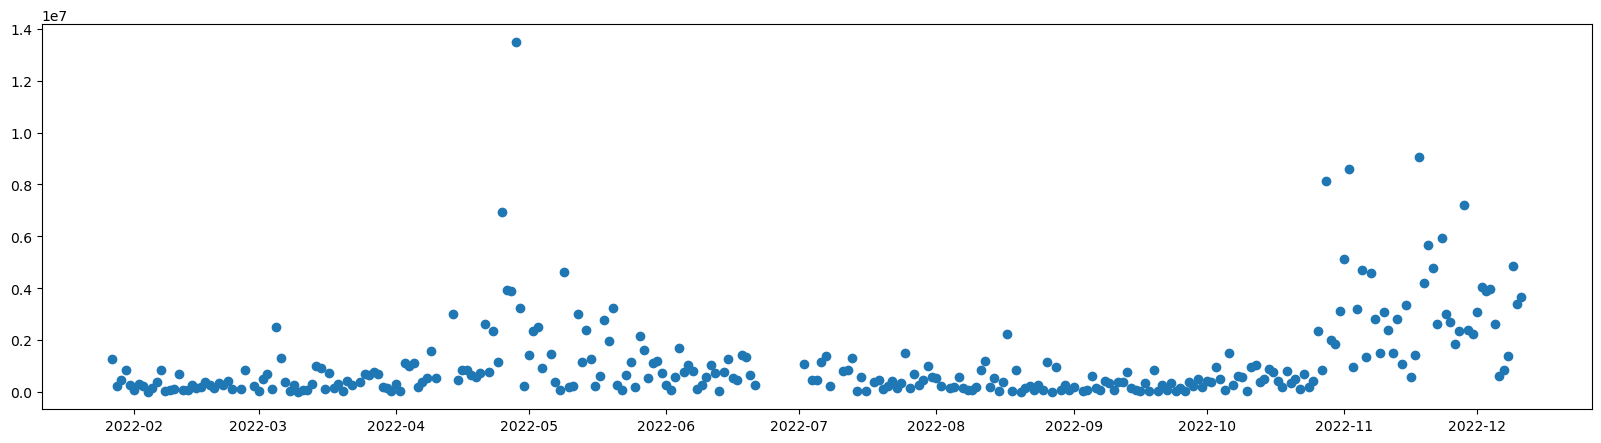

In [16]:
# likes per day
dates_sum_group = df.groupby(by="date", as_index=False).sum()

plt.figure(figsize=(20,5))
plt.scatter(dates_sum_group["date"], dates_sum_group["likes"])

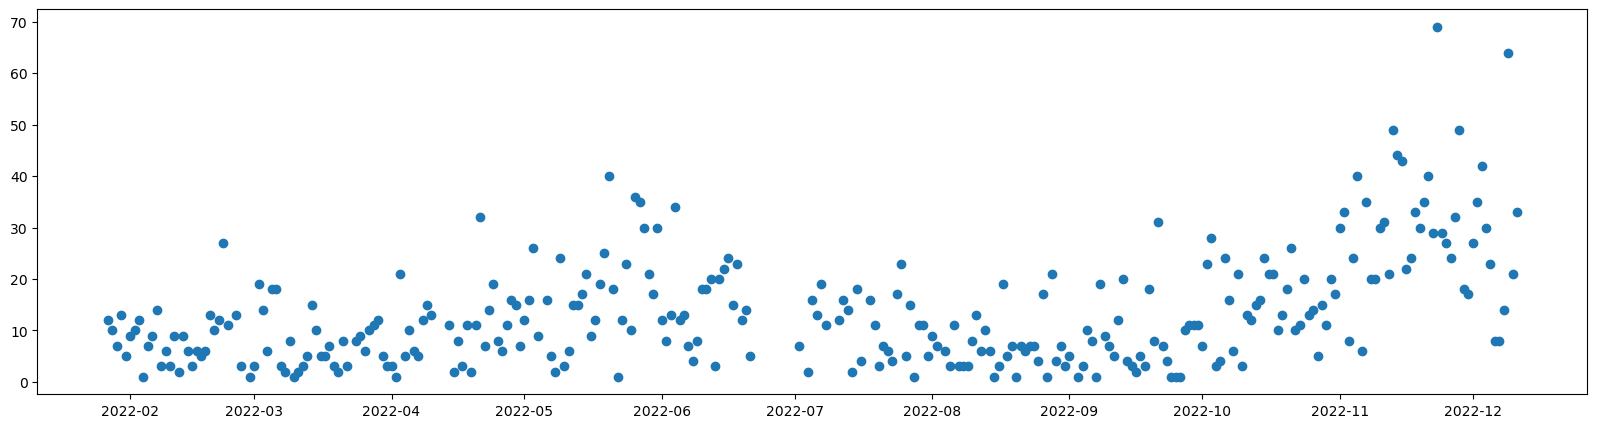

In [17]:
dates_count_group = df.groupby(by="date", as_index=False).count()

plt.figure(figsize=(20,5))
plt.scatter(dates_count_group["date"], dates_count_group["text"])

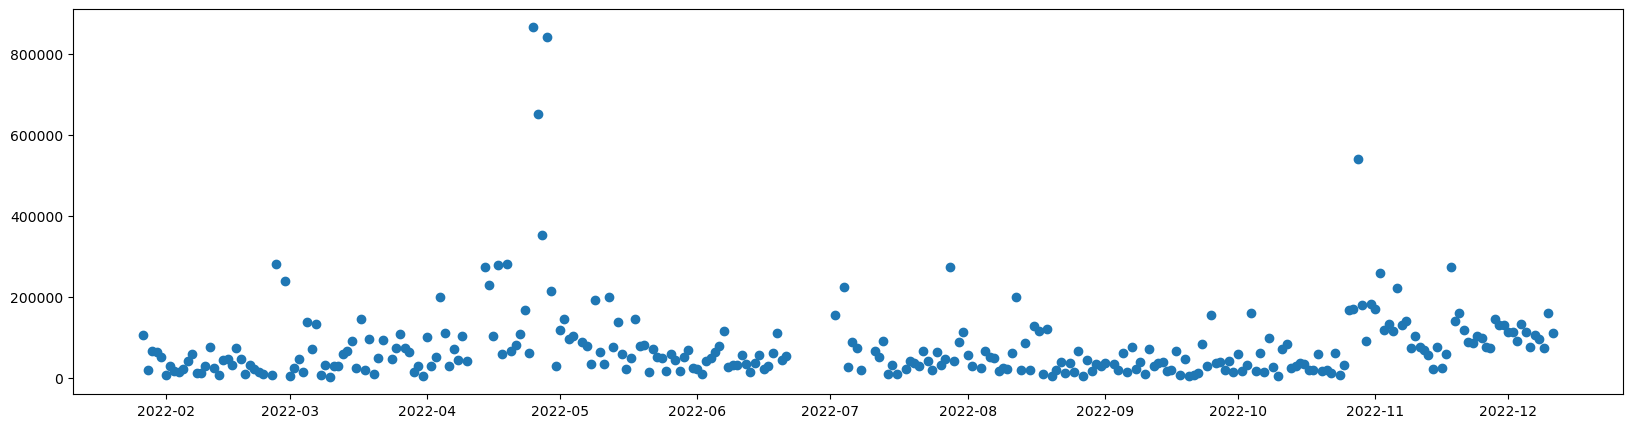

In [18]:
df_likes_to_tweets = dates_sum_group.copy()
df_likes_to_tweets["text"] = dates_count_group["text"]
df_likes_to_tweets["likes/tweets"] = df_likes_to_tweets.apply(lambda x: x["likes"]/x["text"], axis=1)


plt.figure(figsize=(20,5))
plt.scatter(df_likes_to_tweets["date"], df_likes_to_tweets["likes/tweets"])

In [19]:
df[df["date"] == dt(2022, 4, 28)]

,text,likes,retweets,date,cleaned_text
1935,“Real magic is only a sip away.”\n(Actual slog...,425103,20786,2022-04-28,“Real magic is only a sip away.”\n(Actual slog...
1936,.@CocaCola Oh hi lol https://t.co/VhhVM9GzLJ,625037,42793,2022-04-28,. Oh hi lol
1937,@BillyM2k Same,64418,1497,2022-04-28,Same
1938,@walterkirn Freedom of speech means freedom of...,271336,20619,2022-04-28,Freedom of speech means freedom of speech
1939,@scrowder Discomforting,66614,4285,2022-04-28,Discomforting
1940,@DavidSacks @willcain Accurate interview,27234,1254,2022-04-28,Accurate interview
1941,@WatcherGuru FCC FTW!,64698,3419,2022-04-28,FCC FTW!
1942,@pmarca Sounds like satire,37765,1720,2022-04-28,Sounds like satire
1943,@DrRamblings @BillyM2k Great show!,15196,323,2022-04-28,Great show!
1944,@dogeofficialceo Trumpet is legit a way better...,69642,2209,2022-04-28,Trumpet is legit a way better name


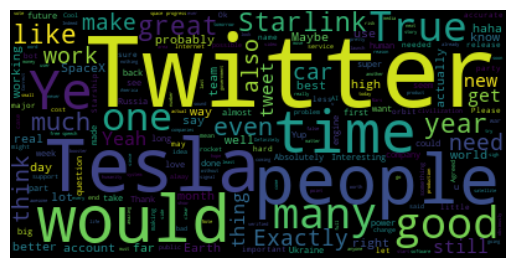

In [21]:
# Create stopword list:
stops = set(stopwords.words('english') + list(string.punctuation))
stops.add("amp")
stops.add("…")
stops.add("’")
stops.add("“")
stops.add("”")
textt = " ".join(tweet for tweet in df["cleaned_text"])
wordcloud = WordCloud(stopwords=stops).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

In [22]:
all_tweets = df["cleaned_text"].str.cat(sep=" ").strip()
words: list[str] = [w for w in nltk.word_tokenize(all_tweets) if w not in stops]
fd = nltk.FreqDist(words)
fd.most_common(10)

finder = nltk.collocations.TrigramCollocationFinder.from_words(words)
finder.ngram_fd.most_common(10)

[(('Tesla', 'AI', 'Day'), 6),
 (('The', 'New', 'York'), 5),
 (('New', 'York', 'Times'), 5),
 (('result', 'account', 'suspension'), 5),
 (('make', 'life', 'multiplanetary'), 5),
 (('The', 'Twitter', 'Files'), 4),
 (('I', 'think', 'I'), 4),
 (('free', 'speech', 'America'), 4),
 (('woke', 'mind', 'virus'), 4),
 (('Vox', 'Populi', 'Vox'), 4)]

In [23]:
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
df["neg"] = df["cleaned_text"].apply(lambda x: 1 if sia.polarity_scores(x)["compound"] <= 0 else 0)
# df["Neu"] = df["cleaned_text"].apply(lambda x: 1 if sia.polarity_scores(x)["neu"] >= 0.5 else 0)
df["pos"] = df["cleaned_text"].apply(lambda x: 1 if sia.polarity_scores(x)["compound"] > 0 else 0)


# df["Neg"] = df["Tweets"].apply(lambda x: sia.polarity_scores(x)["neg"])
# df["Neu"] = df["Tweets"].apply(lambda x: sia.polarity_scores(x)["neu"])
# df["Pos"] = df["Tweets"].apply(lambda x: sia.polarity_scores(x)["pos"])


# test_df = df[(df["Neg"] < 0.5) & (df["Neu"] < 0.5) & (df["Pos"] < 0.5)]
# print(len(test_df))
# test_df
# sia.polarity_scores("Wow, NLTK is really powerful!")
# df.head(n=100)

# for tweet in df["Cleaned_Tweets"].tolist():
#     print(tweet, sia.polarity_scores(tweet))

<BarContainer object of 2 artists>

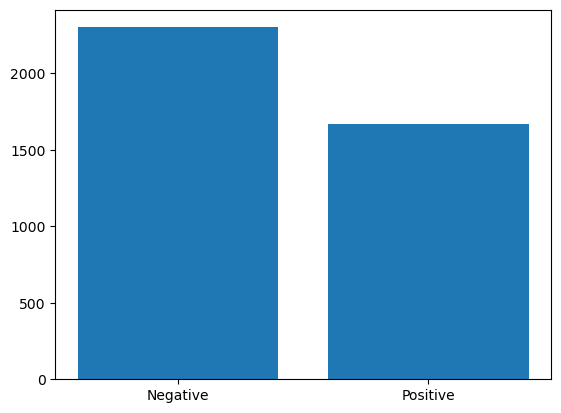

In [24]:
values = [df["neg"].sum(), df["pos"].sum()]
plt.bar(x=["Negative", "Positive"], height=values)

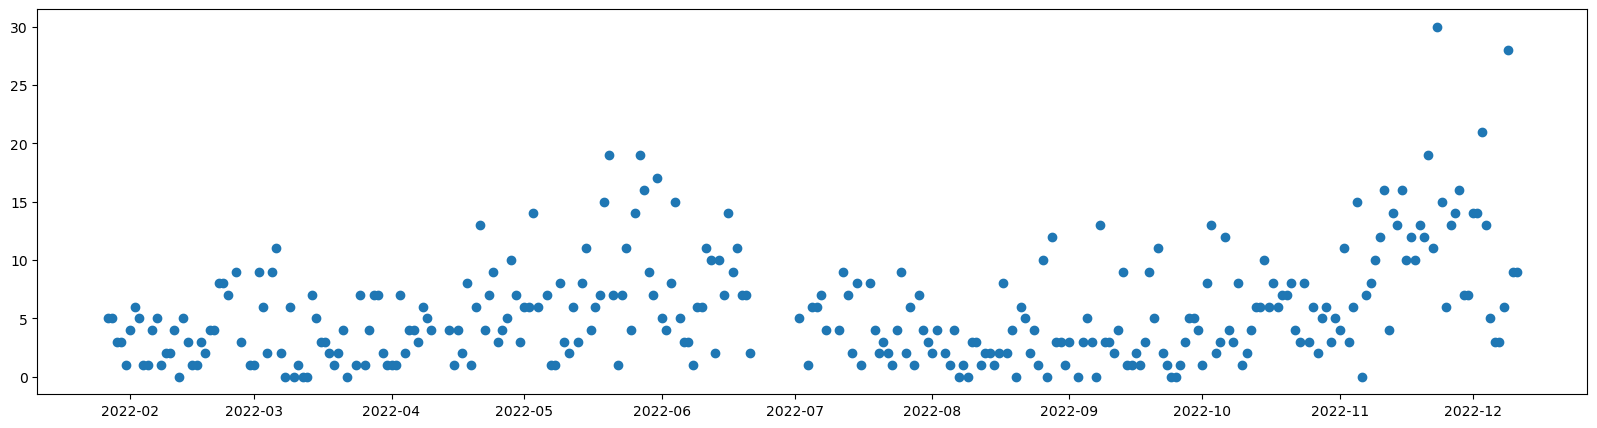

In [25]:
pos_date_group = df.groupby(by="date", as_index=False).sum()
plt.figure(figsize=(20,5))
plt.scatter(x=pos_date_group["date"], y=pos_date_group["pos"])

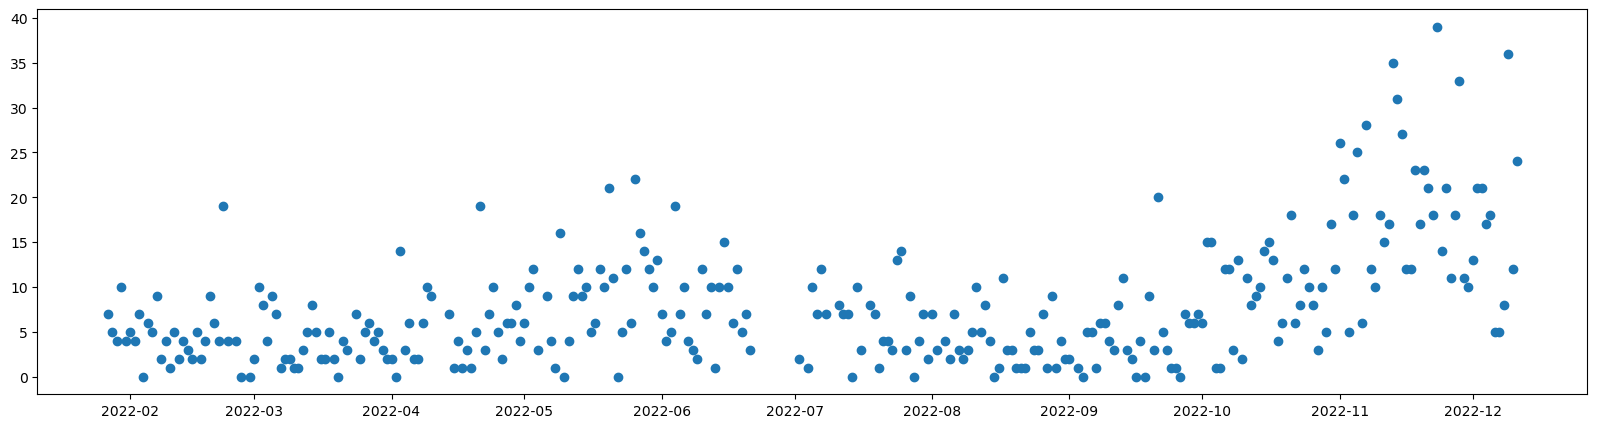

In [26]:
pos_date_group = df.groupby(by="date", as_index=False).sum()
plt.figure(figsize=(20,5))
plt.scatter(x=pos_date_group["date"], y=pos_date_group["neg"])

In [29]:
csv_df[csv_df["Date"] == dt(2022,10,18)]

,Tweets,Retweets,Likes,Date,Cleaned_Tweets
108,@atrupar Smart? Maybe. \nDoes dumb stuff? Defi...,589,12432,2022-10-18,Smart? Maybe. Does dumb stuff? Definitely!
109,@balajis True,102,2671,2022-10-18,True
110,@520AlRihla Exactly,64,1531,2022-10-18,Exactly
111,@larryronaldpar1 Should I make weapons? Ideall...,205,3868,2022-10-18,"Should I make weapons? Ideally, not."
112,@TeslaHype An easy prediction,160,4861,2022-10-18,An easy prediction
113,Drone War I\nhttps://t.co/erVME0CbbN,5267,55658,2022-10-18,Drone War I
114,@teslaownersSV (Actually) Smart Summon is almo...,785,15877,2022-10-18,(Actually) Smart Summon is almost done
115,@Teslaconomics Yes,571,12232,2022-10-18,Yes
116,@stoolpresidente I have a plan,2331,64821,2022-10-18,I have a plan
117,@TeslaAIBot @SpaceX @Tesla Thanks Optimus :),708,18697,2022-10-18,Thanks Optimus :)
